In [1]:
from keras import backend as K
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from models.models import get_model
from losses import make_loss
import os
import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()
import numpy as np
from matplotlib.image import imread
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
from keras.metrics import  binary_accuracy


Using TensorFlow backend.


In [2]:
from dataloaders.inria_datagenerator import InriaDatagenerator
from segmentation_models.backbones import get_preprocessing as process_image
from dataloaders.Losses import my_iou_metric as iou_score

In [3]:
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="1"; 
config = tf.ConfigProto()
session = tf.Session(config=config)
K.set_session(session)


In [4]:
import matplotlib.pyplot as plt
def show_sample(img, lbl):
    #img = img.astype(np.uint8)
    C = None
    try:
        H, W, C = lbl.shape
    except:
        H, W =lbl.shape
    if C is None:
        fig = plt.figure()
        fig.add_subplot(1,2,1)
        plt.suptitle("Image")
        plt.imshow(img)
        fig.add_subplot(1,2,2)
        plt.imshow(lbl, cmap = 'bone')
        plt.suptitle("Mask")
        plt.pause(0.001)  # pause a bit so that plots are updated
        plt.show()
    else:
        fig = plt.figure()
        fig.add_subplot(1, 3, 1)
        plt.suptitle("Image")
        plt.imshow(img)
        fig.add_subplot(1, 3, 2)
        plt.imshow(lbl[:,:,0], cmap='bone')
        plt.suptitle("Mask class 1")
        fig.add_subplot(1, 3, 3)
        plt.imshow(lbl[:, :, 1], cmap='bone')
        plt.suptitle("Mask class 2")
        plt.pause(0.001)  # pause a bit so that plots are updated
        plt.show()


The number of training samples is =  15299, validation samples is = 2445


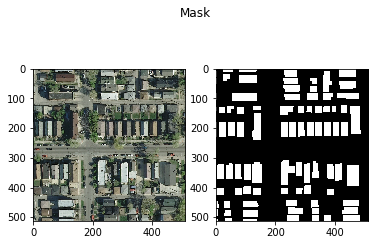

In [5]:
BACKBONE = 'resnext50'
preprocess_input = process_image(BACKBONE)

# load original dataset
import glob
X_train = sorted(glob.glob("/data/margokat/inria/clean_data/train_frames/*.png"))
y_train = sorted(glob.glob("/data/margokat/inria/clean_data/train_masks/*.png"))
X_val = sorted(glob.glob("/data/margokat/inria/clean_data/val_frames/*.png"))
y_val = sorted(glob.glob("/data/margokat/inria/clean_data/val_masks/*.png"))
print('The number of training samples is =  %d, validation samples is = %d' % (len(X_train), len(X_val)))


# calculate coverage
coverage_train = {}
gr_truth = np.zeros((len(y_train ),1))
for i in range(len(y_train )):
    mask = imread(y_train [i])
    H, W = mask.shape
    gr_truth[i] =  np.sum(mask) / (H*W)
    coverage_train[y_train[i]] = gr_truth[i]

coverage_val = {}
gr_truth = np.zeros((len(y_val ),1))
for i in range(len(y_val )):
    mask = imread(y_val[i])
    H, W = mask.shape
    gr_truth[i] =  np.sum(mask) / (H*W)
    coverage_val[y_val[i]] = gr_truth[i]


# In[15]:


# define parameters for sampling

params = {'dim': (512, 512),
          'batch_size': 5,
          'n_channels_img':3,
          'n_channel_mask':1,
          'shuffle': False,
          'Flip': True}

training_generator = InriaDatagenerator(X_train, y_train, Transform = True, stratified_sampling=False, coverage=coverage_train, Process_function = preprocess_input, **params)

params = {'dim': (512, 512),
          'batch_size': 1,
          'n_channels_img':3,
          'n_channel_mask':1,
          'shuffle': False}

validation_generator = InriaDatagenerator(X_val, y_val, Transform = True, stratified_sampling=False, coverage=coverage_val, Process_function = preprocess_input, **params)
(X,y) = validation_generator.__getitem__(500, processing = False)
for i in range(X.shape[0]):
    show_sample(X[i,:].astype(int), np.squeeze(y[i,:]))


In [6]:
def sig_iou_score(y_true, y_pred):
    return iou_score(y_true, y_pred) # tf.math.sigmoid(y_pred)

def sigm_binary_accuracy(y_true, y_pred):
    return binary_accuracy(y_true, y_pred )  #tf.math.sigmoid(y_pred)


In [8]:
# Get the model
loss_function ='bce_dice'
model = get_model(network = 'unet_resnext_50',input_shape=(512, 512, 3), freeze_encoder=False)
Adam_opt =Adam(lr=0.0001,  beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)#, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.001, amsgrad=True)
weight_path = '/data/margokat/models_saved/inria/resnext50_unet_bes_csse_block_weights.best.hdf5'
model.compile(Adam_opt, loss=make_loss(loss_function), metrics=[sig_iou_score, sigm_binary_accuracy])
model.load_weights(weight_path) # if to continue training

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    


In [ ]:
loss_function ='bce_dice'
loss_history = []
weight_path = "/data/margokat/models_saved/inria/{}_weights.best.hdf5".format('resnext50_unet_bes_csse_block')
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min', save_weights_only=True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=2, verbose=1, mode='auto',
                                   epsilon=0.0001, cooldown=4, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=15)  # probably needs to be more patient, but kaggle time is limited

tboard = TensorBoard(log_dir='Graph_resnext50_unet_512_modif_transpose/sse_block/', histogram_freq=0,  
          write_graph=True, write_images=True)

callbacks_list = [checkpoint, early, tboard]

# fit the model
print('Training the model...')
model.compile(Adam_opt, loss=make_loss(loss_function), metrics=[sig_iou_score, sigm_binary_accuracy])
#model.load_weights(weight_path) # if to continue training
loss_history = model.fit_generator(generator=training_generator, steps_per_epoch=np.ceil(len(X_train)/params['batch_size']),
        epochs=120,
        validation_data=validation_generator, validation_steps=int(len(X_val)/params['batch_size']),
        use_multiprocessing=False,
        callbacks=callbacks_list, initial_epoch = 0)

In [9]:
### VALIDATION
steps = np.floor(len(validation_generator.list_IDs)/params['batch_size'])
print('Total steps to cover all the test set data %d' %steps)
out_parms = model.evaluate_generator(validation_generator , steps = steps)
print('\n')
for k,v in zip(model.metrics_names, out_parms):
    print(k,'%2.2f' % v)

Total steps to cover all the test set data 2445


loss 0.30
sig_iou_score 0.51
sigm_binary_accuracy 0.95


In [10]:
SMOOTH = 1e-12
def iou_score_batch(gt, pr):
    ''' function to calculate the mean IOU for a batch, calculating only for
    the positive class
    '''
    batch_size = gt.shape[0]
    average_per_batch = batch_size
    IOU_total = 0;
    for i in range(batch_size):
        # calculate the ground truth coverage per sample
        gt_mask = gt[i,:]
        H, W, C = gt_mask.shape
        coverage_gt = np.sum(gt_mask) / (H * W) 
        coverage_pr = np.sum(pr[i,:]) / (H * W)  
        if coverage_gt == 0 and coverage_pr == 0:
            IOU_total += 1.0
        elif coverage_gt == 0 and coverage_pr != 0:
        	IOU_total += 0.0     
        else:
            IOU_total += jaccard_similarity_margo(gt_mask, pr[i,:])

    return IOU_total/average_per_batch

def jaccard_similarity_margo(gt, pr, smooth=SMOOTH):
    intersection = np.sum(np.sum(gt * pr))
    union = np.sum(np.sum(gt))+ np.sum(np.sum(pr))- intersection
    iou = (intersection + smooth) / (union + smooth)

    return iou

In [11]:
def get_optimal_thresold_dataset(thresholds, validation_generator, steps):
    ious = np.zeros(thresholds.shape)
    for i in range(int(steps)):
        (X,y) = validation_generator. __getitem__(i)
        dm_pred =  model.predict([X]) #iou_score(y[i,:], dm_pred[i,:],smooth = 1e-1).eval(session=sess))
        #ious += ([iou_score(y, np.int32(dm_pred > threshold),smooth = 1e-1).eval(session=sess) for threshold in thresholds])
        ious += np.array([iou_score_batch(y, dm_pred > threshold) for threshold in thresholds])
    ious /=steps
    return ious

In [12]:
## Scoring for last model
steps = np.floor(len(validation_generator.list_IDs)/params['batch_size'])
print(steps)
thresholds = np.linspace(0.0, 0.8, 25)
ious = get_optimal_thresold_dataset(thresholds, validation_generator, int(steps))

2445.0


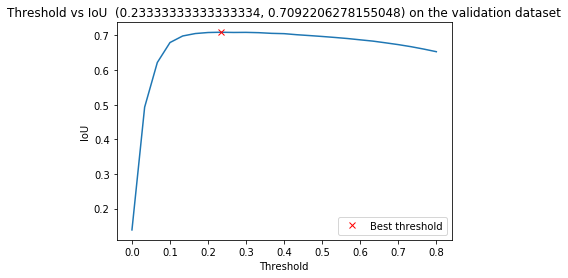

In [13]:
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU  ({}, {}) on the validation dataset".format(threshold_best, iou_best))
plt.legend()